In [11]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import cv2
#import keras
import time
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import segmentation_models as sm
sm.set_framework('tf.keras')
from numpy import array, newaxis, expand_dims

In [12]:
DATA_DIR = 'F:/School/UCT_4th_year/EEE4022S/Notebooks/thesis_practice/acfr_data/'

x_train_dir = os.path.join(DATA_DIR, 'train')
y_train_dir = os.path.join(DATA_DIR, 'trainannot')

x_valid_dir = os.path.join(DATA_DIR, 'val')
y_valid_dir = os.path.join(DATA_DIR, 'valannot')

x_test_dir = os.path.join(DATA_DIR, 'test')
y_test_dir = os.path.join(DATA_DIR, 'testannot')

In [13]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()
    
# helper function for data visualization    
def denormalize(x):
    """Scale image to range 0..1 for correct plot"""
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)    
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x
    
def rgb_to_categorical(mask):
    
    
    
    new_mask = np.zeros((384,384))  
    new_mask=new_mask.astype(int)
    for i in range (384):
        for j in range (384):
            
            if mask[i,j,0]==0 and mask[i,j,1]==0 and mask[i,j,2]==0:
                new_mask[i,j]=int(0)
            elif mask[i,j,0]==128 and mask[i,j,1]==64 and mask[i,j,2]==128:
                new_mask[i,j]=int(1)
            elif mask[i,j,0]==128 and mask[i,j,1]==128 and mask[i,j,2]==128:
                new_mask[i,j]=int(2)
            elif mask[i,j,0]==128 and mask[i,j,1]==128 and mask[i,j,2]==0:
                new_mask[i,j]=int(3)
            elif mask[i,j,0]==128 and mask[i,j,1]==0 and mask[i,j,2]==0:
                new_mask[i,j]=int(4)
            elif mask[i,j,0]==64 and mask[i,j,1]==0 and mask[i,j,2]==128:
                new_mask[i,j]=int(5)
            elif mask[i,j,0]==64 and mask[i,j,1]==64 and mask[i,j,2]==0:
                new_mask[i,j]=int(6)
            elif mask[i,j,0]==64 and mask[i,j,1]==64 and mask[i,j,2]==128:
                new_mask[i,j]=int(7)
            elif mask[i,j,0]==192 and mask[i,j,1]==192 and mask[i,j,2]==128:
                new_mask[i,j]=int(8)
            elif mask[i,j,0]==0 and mask[i,j,1]==0 and mask[i,j,2]==128:
                new_mask[i,j]=int(9)
            elif mask[i,j,0]==128 and mask[i,j,1]==64 and mask[i,j,2]==64:
                new_mask[i,j]=int(10)  
                
    return new_mask

def categorical_to_rgb(mask):
    
    
    
    new_mask = np.zeros((384,384,3))  
    new_mask=new_mask.astype(int)
    thresh=0.35
    for i in range (384):
        for j in range (384):
            
            if mask[i,j,0]>=thresh:
                new_mask[i,j,0]=int(0)
                new_mask[i,j,1]=int(0)
                new_mask[i,j,2]=int(0)
            elif mask[i,j,1]>=thresh:
                new_mask[i,j,0]=int(128)
                new_mask[i,j,1]=int(64)
                new_mask[i,j,2]=int(128)
            elif mask[i,j,2]>=thresh:
                new_mask[i,j,0]=int(128)
                new_mask[i,j,1]=int(128)
                new_mask[i,j,2]=int(128)
            elif mask[i,j,3]>=thresh:
                new_mask[i,j,0]=int(128)
                new_mask[i,j,1]=int(128)
                new_mask[i,j,2]=int(0)
            elif mask[i,j,4]>=thresh:
                new_mask[i,j,0]=int(128)
                new_mask[i,j,1]=int(0)
                new_mask[i,j,2]=int(0)
            elif mask[i,j,5]>=thresh:
                new_mask[i,j,0]=int(64)
                new_mask[i,j,1]=int(0)
                new_mask[i,j,2]=int(128)
            elif mask[i,j,6]>=thresh:
                new_mask[i,j,0]=int(64)
                new_mask[i,j,1]=int(64)
                new_mask[i,j,2]=int(0)
            elif mask[i,j,7]>=thresh:
                new_mask[i,j,0]=int(64)
                new_mask[i,j,1]=int(64)
                new_mask[i,j,2]=int(128)
            elif mask[i,j,8]>=thresh:
                new_mask[i,j,0]=int(192)
                new_mask[i,j,1]=int(192)
                new_mask[i,j,2]=int(128)
            elif mask[i,j,9]>=thresh:
                new_mask[i,j,0]=int(0)
                new_mask[i,j,1]=int(0)
                new_mask[i,j,2]=int(128)
            elif mask[i,j,0]>=thresh:
                new_mask[i,j,0]=int(128)
                new_mask[i,j,1]=int(64)
                new_mask[i,j,2]=int(64)
                
    return new_mask
    
# classes for data loading and preprocessing
class Dataset:
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    CLASSES = ['undefined', 'ground', 'sky', 'vegetation', 'building', 
               'vehicle', 'human', 'fence', 'pole', 
               'cow', 'other']
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i])
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
        
        image=cv2.resize(image,(384,384),interpolation=cv2.INTER_AREA)
        mask=cv2.resize(mask,(384,384),interpolation=cv2.INTER_AREA)
        
        
        mask=rgb_to_categorical(mask)        
        
        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        mask=mask.astype(np.float32)
        
         #add background if mask is not binary
        #if mask.shape[-1] != 1:
        #    background = 1 - mask.sum(axis=-1, keepdims=True)
        #    mask = np.concatenate((mask, background), axis=-1)
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.ids)
    
    
class Dataloder(tf.keras.utils.Sequence):
    """Load data from dataset and form batches
    
    Args:
        dataset: instance of Dataset class for image loading and preprocessing.
        batch_size: Integet number of images in batch.
        shuffle: Boolean, if `True` shuffle image indexes each epoch.
    """
    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

        self.on_epoch_end()

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            #datapoint=self.dataset[j]
            #newdatapoint = np.expand_dims(datapoint,0)
            data.append(self.dataset[j])
        
        # transpose list of lists
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return batch
    
    def __len__(self):
        """Denotes the number of batches per epoch"""
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        """Callback function to shuffle indexes each epoch"""
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)

In [14]:
import albumentations as A

def round_clip_0_1(x, **kwargs):
    return x.round().clip(0, 1)

# define heavy augmentations
def get_training_augmentation():
    train_transform = [

        A.HorizontalFlip(p=0.5),

        A.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        A.PadIfNeeded(min_height=384, min_width=384, always_apply=True, border_mode=0),
        A.RandomCrop(height=384, width=384, always_apply=True),

        A.IAAAdditiveGaussianNoise(p=0.2),
        A.IAAPerspective(p=0.5),

        A.OneOf(
            [
                A.CLAHE(p=1),
                A.RandomBrightness(p=1),
                A.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.IAASharpen(p=1),
                A.Blur(blur_limit=3, p=1),
                A.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.RandomContrast(p=1),
                A.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
        A.Lambda(mask=round_clip_0_1)
    ]
    return A.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        A.PadIfNeeded(384, 384)
    ]
    return A.Compose(test_transform)

def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        A.Lambda(image=preprocessing_fn),
    ]
    return A.Compose(_transform)

In [38]:

BACKBONE = 'resnet34'

PRE_TRAINED_WEIGHTS='imagenet'

BATCH_SIZE = 5
CLASSES = ['undefined','ground', 'sky', 'vegetation', 'building', 'vehicle', 'human', 'fence', 'pole', 'cow', 'other']
LR = 0.0001
EPOCHS = 19
preprocess_input = sm.get_preprocessing(BACKBONE)

In [39]:
n_classes = 1 if len(CLASSES) == 1 else (len(CLASSES))  # case for binary and multiclass segmentation
activation = 'sigmoid' if n_classes == 1 else 'softmax'

#create model
model = sm.FPN(BACKBONE, encoder_weights = PRE_TRAINED_WEIGHTS, classes=n_classes) #encoder_freeze = True,

In [40]:

# define optomizer
optim = tf.keras.optimizers.Adam(learning_rate=LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
# set class weights for dice_loss (car: 1.; pedestrian: 2.; background: 0.5;)
dice_loss = sm.losses.DiceLoss(class_weights=np.array([1,1,1,1,1,1,1,1,1,1,1])) 
focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5),]

# compile keras model with defined optimozer, loss and metrics
loss=tf.keras.losses.CategoricalCrossentropy()
model.compile(optim, loss, metrics)

In [18]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    test_dataset = Dataset(
    x_test_dir, 
    y_test_dir, 
    classes=CLASSES, 
    #augmentation=get_validation_augmentation(),
    #preprocessing=get_preprocessing(preprocess_input),
    )
    
    image, mask = test_dataset[0] # get some sample
    image=np.expand_dims(image,axis=0)
    pr_mask=model.predict(image)
    
    visualize(
    image=image.squeeze(), 
    ground_mask=mask[..., 1].squeeze(),
    vegetation_mask=mask[..., 3].squeeze(),
    pr_ground_mask=pr_mask[..., 1].squeeze(),
    pr_vegetation_mask=pr_mask[..., 3].squeeze(),
    
    )
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

In [19]:
# Dataset for train images
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    classes=CLASSES, 
    #augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

train_dataset_aug1=Dataset(
    x_train_dir, 
    y_train_dir, 
    classes=CLASSES, 
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

train_dataset_aug2=Dataset(
    x_train_dir, 
    y_train_dir, 
    classes=CLASSES, 
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

train_dataset_aug3=Dataset(
    x_train_dir, 
    y_train_dir, 
    classes=CLASSES, 
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

train_dataset_aug4=Dataset(
    x_train_dir, 
    y_train_dir, 
    classes=CLASSES, 
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

train_dataset_aug5=Dataset(
    x_train_dir, 
    y_train_dir, 
    classes=CLASSES, 
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

train_dataset_aug6=Dataset(
    x_train_dir, 
    y_train_dir, 
    classes=CLASSES, 
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

train_dataset_aug7=Dataset(
    x_train_dir, 
    y_train_dir, 
    classes=CLASSES, 
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

train_dataset_aug8=Dataset(
    x_train_dir, 
    y_train_dir, 
    classes=CLASSES, 
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

train_dataset_aug9=Dataset(
    x_train_dir, 
    y_train_dir, 
    classes=CLASSES, 
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

# Dataset for validation images
valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    classes=CLASSES, 
    #augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

valid_dataset_aug1 = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    classes=CLASSES, 
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

valid_dataset_aug2 = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    classes=CLASSES, 
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)
valid_dataset_aug3 = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    classes=CLASSES, 
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

valid_dataset_aug4 = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    classes=CLASSES, 
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)
valid_dataset_aug5 = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    classes=CLASSES, 
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

train_dataloader = Dataloder(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_dataloader_aug1 = Dataloder(train_dataset_aug1, batch_size=BATCH_SIZE, shuffle=True)
train_dataloader_aug2 = Dataloder(train_dataset_aug2, batch_size=BATCH_SIZE, shuffle=True)
train_dataloader_aug3 = Dataloder(train_dataset_aug3, batch_size=BATCH_SIZE, shuffle=True)
train_dataloader_aug4 = Dataloder(train_dataset_aug4, batch_size=BATCH_SIZE, shuffle=True)
train_dataloader_aug5 = Dataloder(train_dataset_aug5, batch_size=BATCH_SIZE, shuffle=True)
train_dataloader_aug6 = Dataloder(train_dataset_aug6, batch_size=BATCH_SIZE, shuffle=True)
train_dataloader_aug7 = Dataloder(train_dataset_aug7, batch_size=BATCH_SIZE, shuffle=True)
train_dataloader_aug8 = Dataloder(train_dataset_aug8, batch_size=BATCH_SIZE, shuffle=True)
train_dataloader_aug9 = Dataloder(train_dataset_aug9, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = Dataloder(valid_dataset, batch_size=1, shuffle=False)
valid_dataloader_aug1 = Dataloder(valid_dataset_aug1, batch_size=1, shuffle=False)
valid_dataloader_aug2 = Dataloder(valid_dataset_aug2, batch_size=1, shuffle=False)
valid_dataloader_aug3 = Dataloder(valid_dataset_aug3, batch_size=1, shuffle=False)
valid_dataloader_aug4 = Dataloder(valid_dataset_aug2, batch_size=1, shuffle=False)


# check shapes for errors
#assert train_dataloader[0][0].shape == (BATCH_SIZE, 320, 320, 3)
#assert train_dataloader[0][1].shape == (BATCH_SIZE, 320, 320, n_classes)

# define callbacks for learning rate scheduling and best checkpoints saving
callbacks = [
    tf.keras.callbacks.ModelCheckpoint('./best_model.h5', save_weights_only=True, save_best_only=True, mode='min'),
    tf.keras.callbacks.ReduceLROnPlateau(),
    DisplayCallback(),
]


In [20]:
start_time = time.time()

#temp=np.array(train_dataloader)
train_image_set_list=[]
train_annot_set_list=[]
for i in range (len(train_dataloader)):
    train_image_set_list.extend(train_dataloader[i][0])
    train_annot_set_list.extend(train_dataloader[i][1])
print('loading 1') 
for i in range (len(train_dataloader_aug1)):
    train_image_set_list.extend(train_dataloader_aug1[i][0])
    train_annot_set_list.extend(train_dataloader_aug1[i][1])
print('loading 2')
for i in range (len(train_dataloader_aug2)):
    train_image_set_list.extend(train_dataloader_aug2[i][0])
    train_annot_set_list.extend(train_dataloader_aug2[i][1])
print('loading 3')    
for i in range (len(train_dataloader_aug3)):
    train_image_set_list.extend(train_dataloader_aug3[i][0])
    train_annot_set_list.extend(train_dataloader_aug3[i][1])
print('loading 4')
for i in range (len(train_dataloader_aug4)):
    train_image_set_list.extend(train_dataloader_aug4[i][0])
    train_annot_set_list.extend(train_dataloader_aug4[i][1])
print('loading 5')    
for i in range (len(train_dataloader_aug5)):
    train_image_set_list.extend(train_dataloader_aug5[i][0])
    train_annot_set_list.extend(train_dataloader_aug5[i][1])
print('loading 6')    
for i in range (len(train_dataloader_aug6)):
    train_image_set_list.extend(train_dataloader_aug6[i][0])
    train_annot_set_list.extend(train_dataloader_aug6[i][1])
print('loading 7')    
for i in range (len(train_dataloader_aug7)):
    train_image_set_list.extend(train_dataloader_aug7[i][0])
    train_annot_set_list.extend(train_dataloader_aug7[i][1])
print('loading 8')    
for i in range (len(train_dataloader_aug8)):
    train_image_set_list.extend(train_dataloader_aug8[i][0])
    train_annot_set_list.extend(train_dataloader_aug8[i][1])
print('loading 9')   
for i in range (len(train_dataloader_aug9)):
    train_image_set_list.extend(train_dataloader_aug9[i][0])
    train_annot_set_list.extend(train_dataloader_aug9[i][1])
print('loading 10')
    
train_image_set=np.array(train_image_set_list)
train_annot_set=np.array(train_annot_set_list)    


val_image_set_list=[]
val_annot_set_list=[]
for i in range (len(valid_dataloader)):
    val_image_set_list.extend(valid_dataloader[i][0])
    val_annot_set_list.extend(valid_dataloader[i][1])
print('loading 1')
for i in range (len(valid_dataloader_aug1)):
    val_image_set_list.extend(valid_dataloader_aug1[i][0])
    val_annot_set_list.extend(valid_dataloader_aug1[i][1])
print('loading 2')
for i in range (len(valid_dataloader_aug2)):
    val_image_set_list.extend(valid_dataloader_aug2[i][0])
    val_annot_set_list.extend(valid_dataloader_aug2[i][1])
print('loading 3')
for i in range (len(valid_dataloader_aug3)):
    val_image_set_list.extend(valid_dataloader_aug3[i][0])
    val_annot_set_list.extend(valid_dataloader_aug3[i][1])
   
print('loading 4')
for i in range (len(valid_dataloader_aug4)):
    val_image_set_list.extend(valid_dataloader_aug4[i][0])
    val_annot_set_list.extend(valid_dataloader_aug4[i][1])
   
print('loading 5')

val_annot_set=np.array(val_annot_set_list)
val_image_set=np.array(val_image_set_list)
print("--- %s seconds ---" % (time.time() - start_time))

loading 1
loading 2
loading 3
loading 4
loading 5
loading 6
loading 7
loading 8
loading 9
loading 10
loading 1
loading 2
loading 3
loading 4
loading 5
--- 2996.0366628170013 seconds ---


In [21]:
print(train_image_set.shape)
print(train_annot_set.shape)
print(val_image_set.shape)
print(val_annot_set.shape)

(1050, 384, 384, 3)
(1050, 384, 384, 11)
(75, 384, 384, 3)
(75, 384, 384, 11)


Epoch 1/19
10/10 [==============================] - 11s 627ms/step - loss: 1.8336 - iou_score: 0.0728 - f1-score: 0.0808 - val_loss: 2.1349 - val_iou_score: 0.2020 - val_f1-score: 0.2304


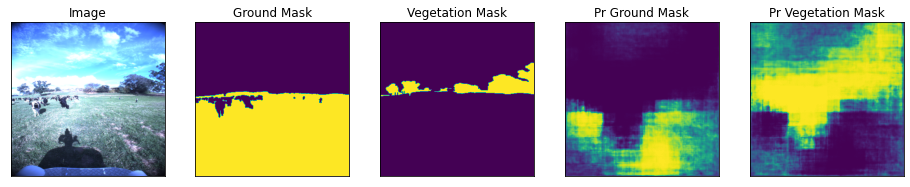


Sample Prediction after epoch 1

Epoch 2/19
10/10 [==============================] - 5s 511ms/step - loss: 1.0243 - iou_score: 0.2242 - f1-score: 0.2614 - val_loss: 1.6812 - val_iou_score: 0.2664 - val_f1-score: 0.2997


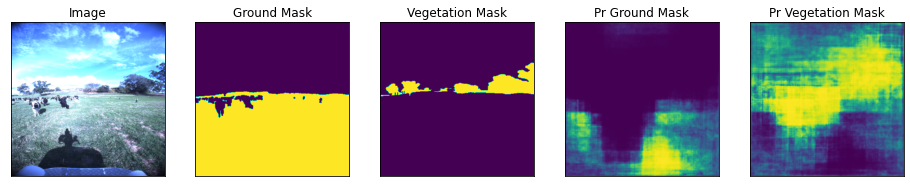


Sample Prediction after epoch 2

Epoch 3/19
10/10 [==============================] - 5s 519ms/step - loss: 0.7577 - iou_score: 0.3476 - f1-score: 0.3854 - val_loss: 1.0379 - val_iou_score: 0.3169 - val_f1-score: 0.3591


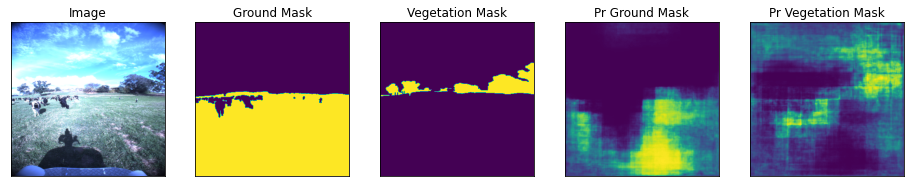


Sample Prediction after epoch 3

Epoch 4/19
10/10 [==============================] - 5s 521ms/step - loss: 0.6781 - iou_score: 0.3516 - f1-score: 0.3872 - val_loss: 0.9209 - val_iou_score: 0.3229 - val_f1-score: 0.3608


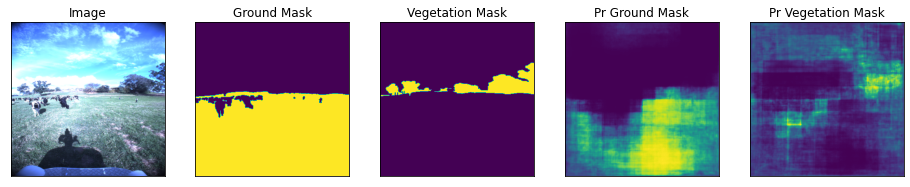


Sample Prediction after epoch 4

Epoch 5/19
10/10 [==============================] - 5s 526ms/step - loss: 0.6251 - iou_score: 0.3153 - f1-score: 0.3499 - val_loss: 0.8093 - val_iou_score: 0.3404 - val_f1-score: 0.3784


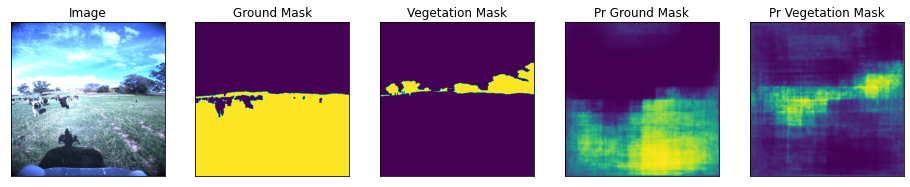


Sample Prediction after epoch 5

Epoch 6/19
10/10 [==============================] - 5s 515ms/step - loss: 0.6238 - iou_score: 0.3919 - f1-score: 0.4299 - val_loss: 0.7968 - val_iou_score: 0.3284 - val_f1-score: 0.3619


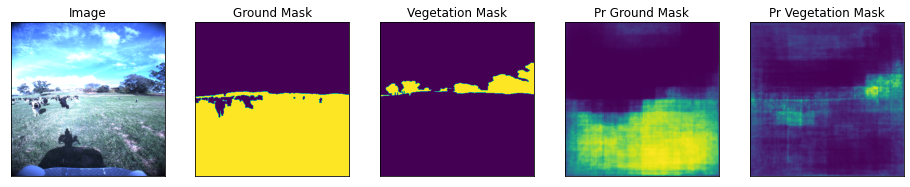


Sample Prediction after epoch 6

Epoch 7/19
10/10 [==============================] - 5s 514ms/step - loss: 0.7158 - iou_score: 0.3387 - f1-score: 0.3734 - val_loss: 0.7117 - val_iou_score: 0.3484 - val_f1-score: 0.3862


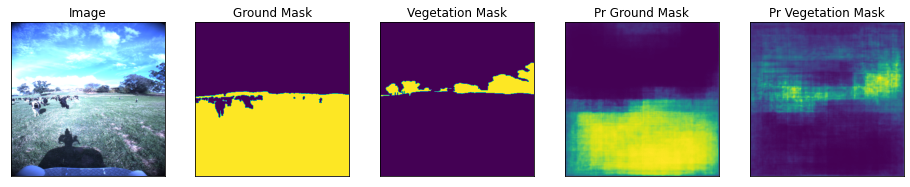


Sample Prediction after epoch 7

Epoch 8/19
10/10 [==============================] - 5s 514ms/step - loss: 0.5455 - iou_score: 0.4002 - f1-score: 0.4411 - val_loss: 0.7302 - val_iou_score: 0.3529 - val_f1-score: 0.3929


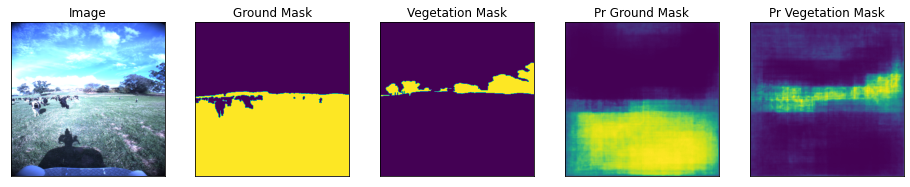


Sample Prediction after epoch 8

Epoch 9/19
10/10 [==============================] - 5s 515ms/step - loss: 0.6667 - iou_score: 0.3241 - f1-score: 0.3629 - val_loss: 0.7300 - val_iou_score: 0.3514 - val_f1-score: 0.3886


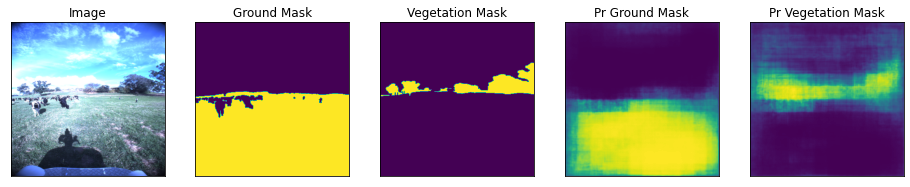


Sample Prediction after epoch 9

Epoch 10/19
10/10 [==============================] - 5s 514ms/step - loss: 0.5780 - iou_score: 0.3275 - f1-score: 0.3669 - val_loss: 0.6555 - val_iou_score: 0.3541 - val_f1-score: 0.3896


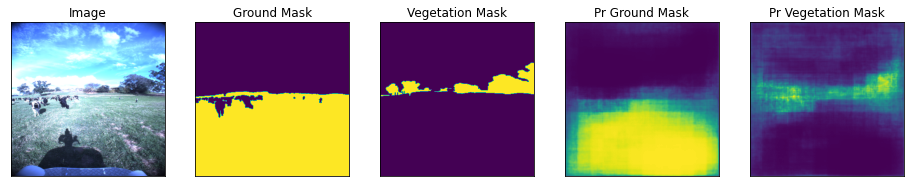


Sample Prediction after epoch 10

Epoch 11/19
10/10 [==============================] - 5s 512ms/step - loss: 0.6335 - iou_score: 0.3561 - f1-score: 0.3932 - val_loss: 0.6805 - val_iou_score: 0.3406 - val_f1-score: 0.3712


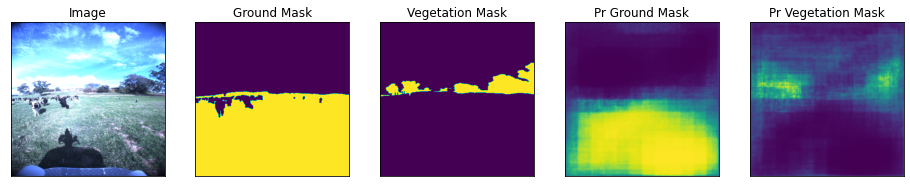


Sample Prediction after epoch 11

Epoch 12/19
10/10 [==============================] - 5s 513ms/step - loss: 0.6292 - iou_score: 0.3564 - f1-score: 0.3913 - val_loss: 0.6647 - val_iou_score: 0.3536 - val_f1-score: 0.3854



Sample Prediction after epoch 12

Epoch 13/19
10/10 [==============================] - 5s 515ms/step - loss: 0.5166 - iou_score: 0.4061 - f1-score: 0.4429 - val_loss: 0.6317 - val_iou_score: 0.3574 - val_f1-score: 0.3881


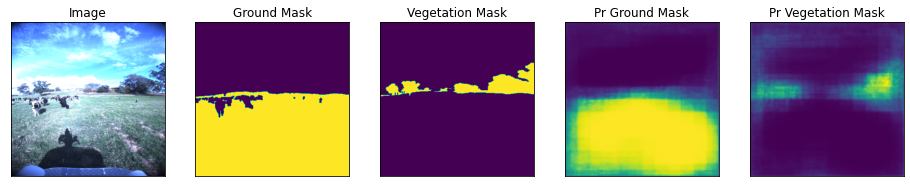


Sample Prediction after epoch 13

Epoch 14/19
10/10 [==============================] - 5s 516ms/step - loss: 0.6285 - iou_score: 0.3479 - f1-score: 0.3846 - val_loss: 0.5426 - val_iou_score: 0.3686 - val_f1-score: 0.4008



Sample Prediction after epoch 14

Epoch 15/19
10/10 [==============================] - 5s 513ms/step - loss: 0.6054 - iou_score: 0.3013 - f1-score: 0.3378 - val_loss: 0.5488 - val_iou_score: 0.3739 - val_f1-score: 0.4102


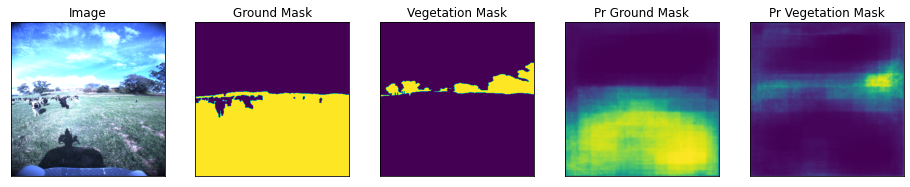


Sample Prediction after epoch 15

Epoch 16/19
10/10 [==============================] - 5s 513ms/step - loss: 0.5592 - iou_score: 0.4653 - f1-score: 0.5022 - val_loss: 0.6229 - val_iou_score: 0.3596 - val_f1-score: 0.3952



Sample Prediction after epoch 16

Epoch 17/19
10/10 [==============================] - 5s 514ms/step - loss: 0.5767 - iou_score: 0.3745 - f1-score: 0.4134 - val_loss: 0.5932 - val_iou_score: 0.3632 - val_f1-score: 0.3963



Sample Prediction after epoch 17

Epoch 18/19
10/10 [==============================] - 5s 515ms/step - loss: 0.6103 - iou_score: 0.3099 - f1-score: 0.3470 - val_loss: 0.5499 - val_iou_score: 0.3642 - val_f1-score: 0.3944



Sample Prediction after epoch 18

Epoch 19/19
10/10 [==============================] - 5s 514ms/step - loss: 0.5922 - iou_score: 0.3263 - f1-score: 0.3637 - val_loss: 0.5209 - val_iou_score: 0.3664 - val_f1-score: 0.3957



Sample Prediction after epoch 19



In [41]:
history = model.fit(
    x=train_image_set,#train_dataloader[0][0],
    y=train_annot_set,#train_dataloader[0][1],
    batch_size=BATCH_SIZE,
    steps_per_epoch=10, 
    epochs=EPOCHS, 
    callbacks=callbacks, 
    validation_data=(val_image_set,val_annot_set), 
    validation_steps=5,
)


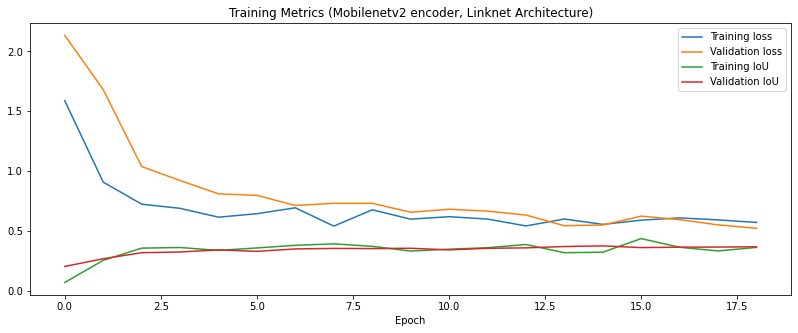

In [42]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
#plt.plot(history.history['accuracy'])
#plt.plot(history.history['val_accuracy'])
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Training Metrics (Mobilenetv2 encoder, Linknet Architecture)')
#plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Training loss', 'Validation loss','Training IoU','Validation IoU'], loc='upper right')


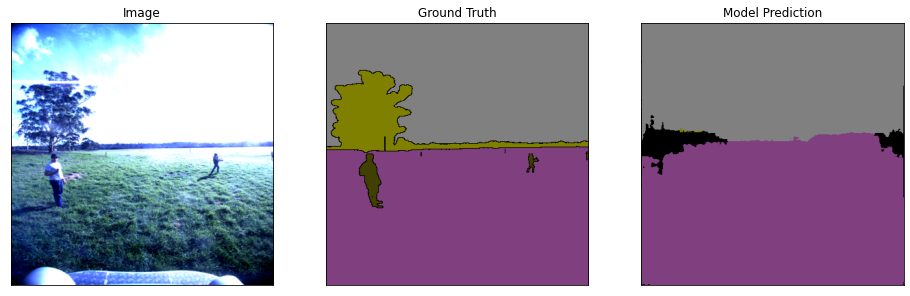

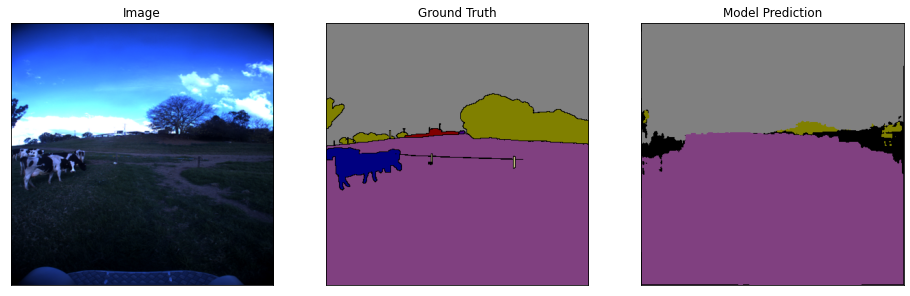

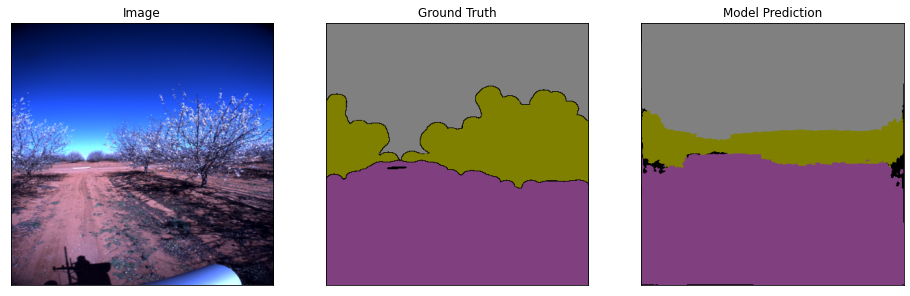

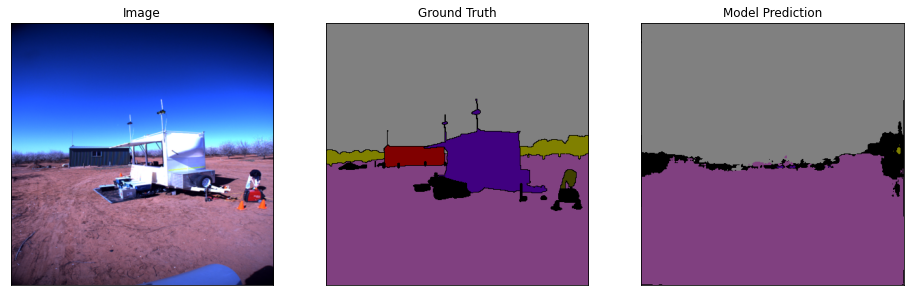

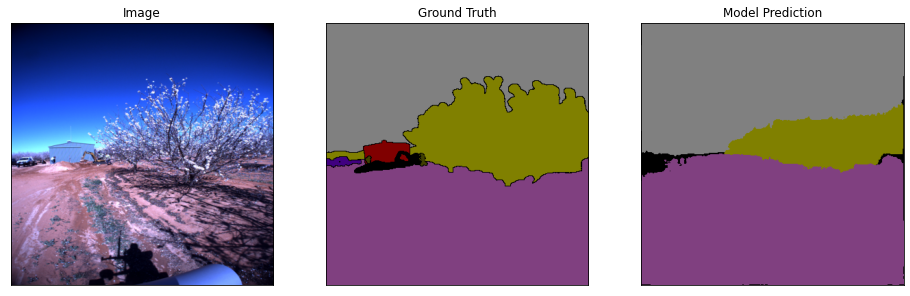

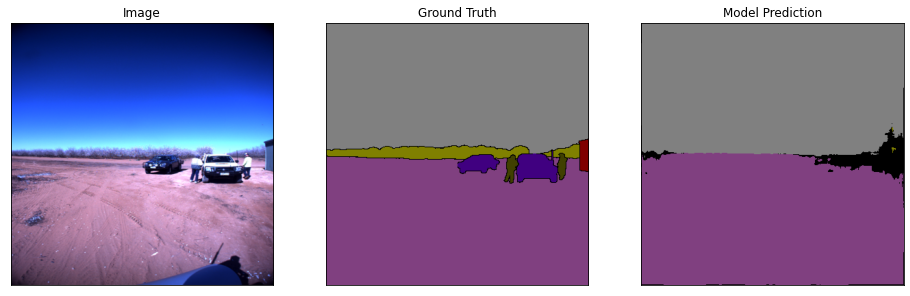

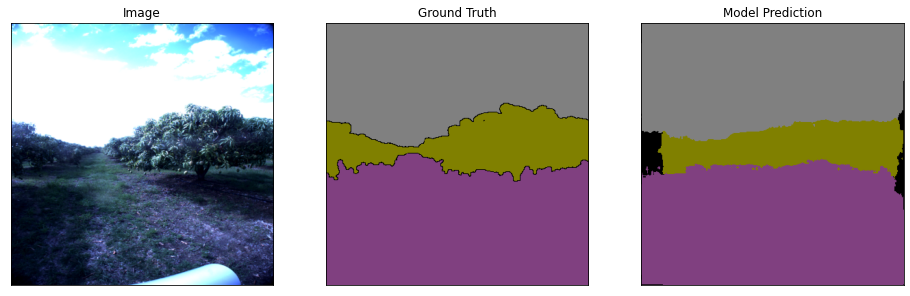

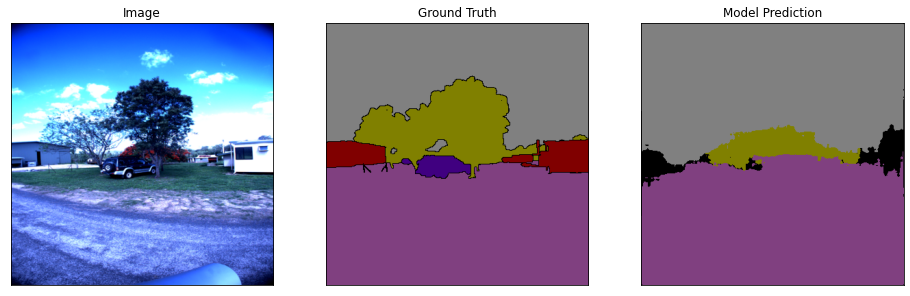

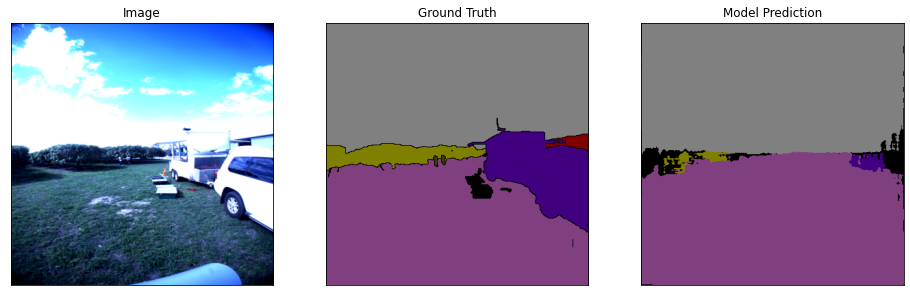

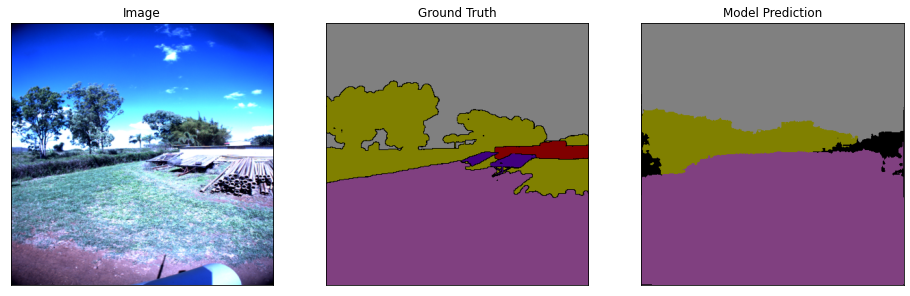

(384, 384, 3)


In [43]:
test_dataset = Dataset(
    x_test_dir, 
    y_test_dir, 
    classes=CLASSES, 
    #augmentation=get_validation_augmentation(),
    #preprocessing=get_preprocessing(preprocess_input),
)


for i in range (len(test_dataset)):

    image, gt_mask = test_dataset[i]
    image=np.expand_dims(image,axis=0)
    pr_mask=model.predict(image)
    pr_mask=pr_mask.squeeze()
    gt_mask=categorical_to_rgb(gt_mask)
    pr_mask=categorical_to_rgb(pr_mask)
    
    visualize(
            image=denormalize(image).squeeze(),
            #gt_mask_ground=gt_mask[...,1].squeeze(),
            Ground_Truth=gt_mask.squeeze(),
            Model_Prediction=pr_mask.squeeze(),
            #pr_mask_veg=pr_mask[...,3].squeeze(),
            #pr_mask_building=pr_mask[...,4].squeeze(),
            #pr_mask_vehicle=pr_mask[...,9].squeeze(),
        )

print(pr_mask.shape)